In [1]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, f1_score, recall_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import lime
import lime.lime_tabular
import shap
import shap
from lime import lime_tabular
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
df = pd.read_csv("/kaggle/input/diabetes.csv")

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### Sample #####################")
    print(dataframe.sample(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 2

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [7]:
print(cat_cols,num_cols,cat_but_car)

['Outcome'] ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'] []


In [8]:
def num_summary(dataframe, numerical_col):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print (dataframe[numerical_col].describe(quantiles).T)
    print("##########################################")

for col in num_cols:
    num_summary(df, col)

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64
##########################################
count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64
##########################################
count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float6

In [9]:
df['Glucose'] = df['Glucose'].replace(0, np.nan)
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)

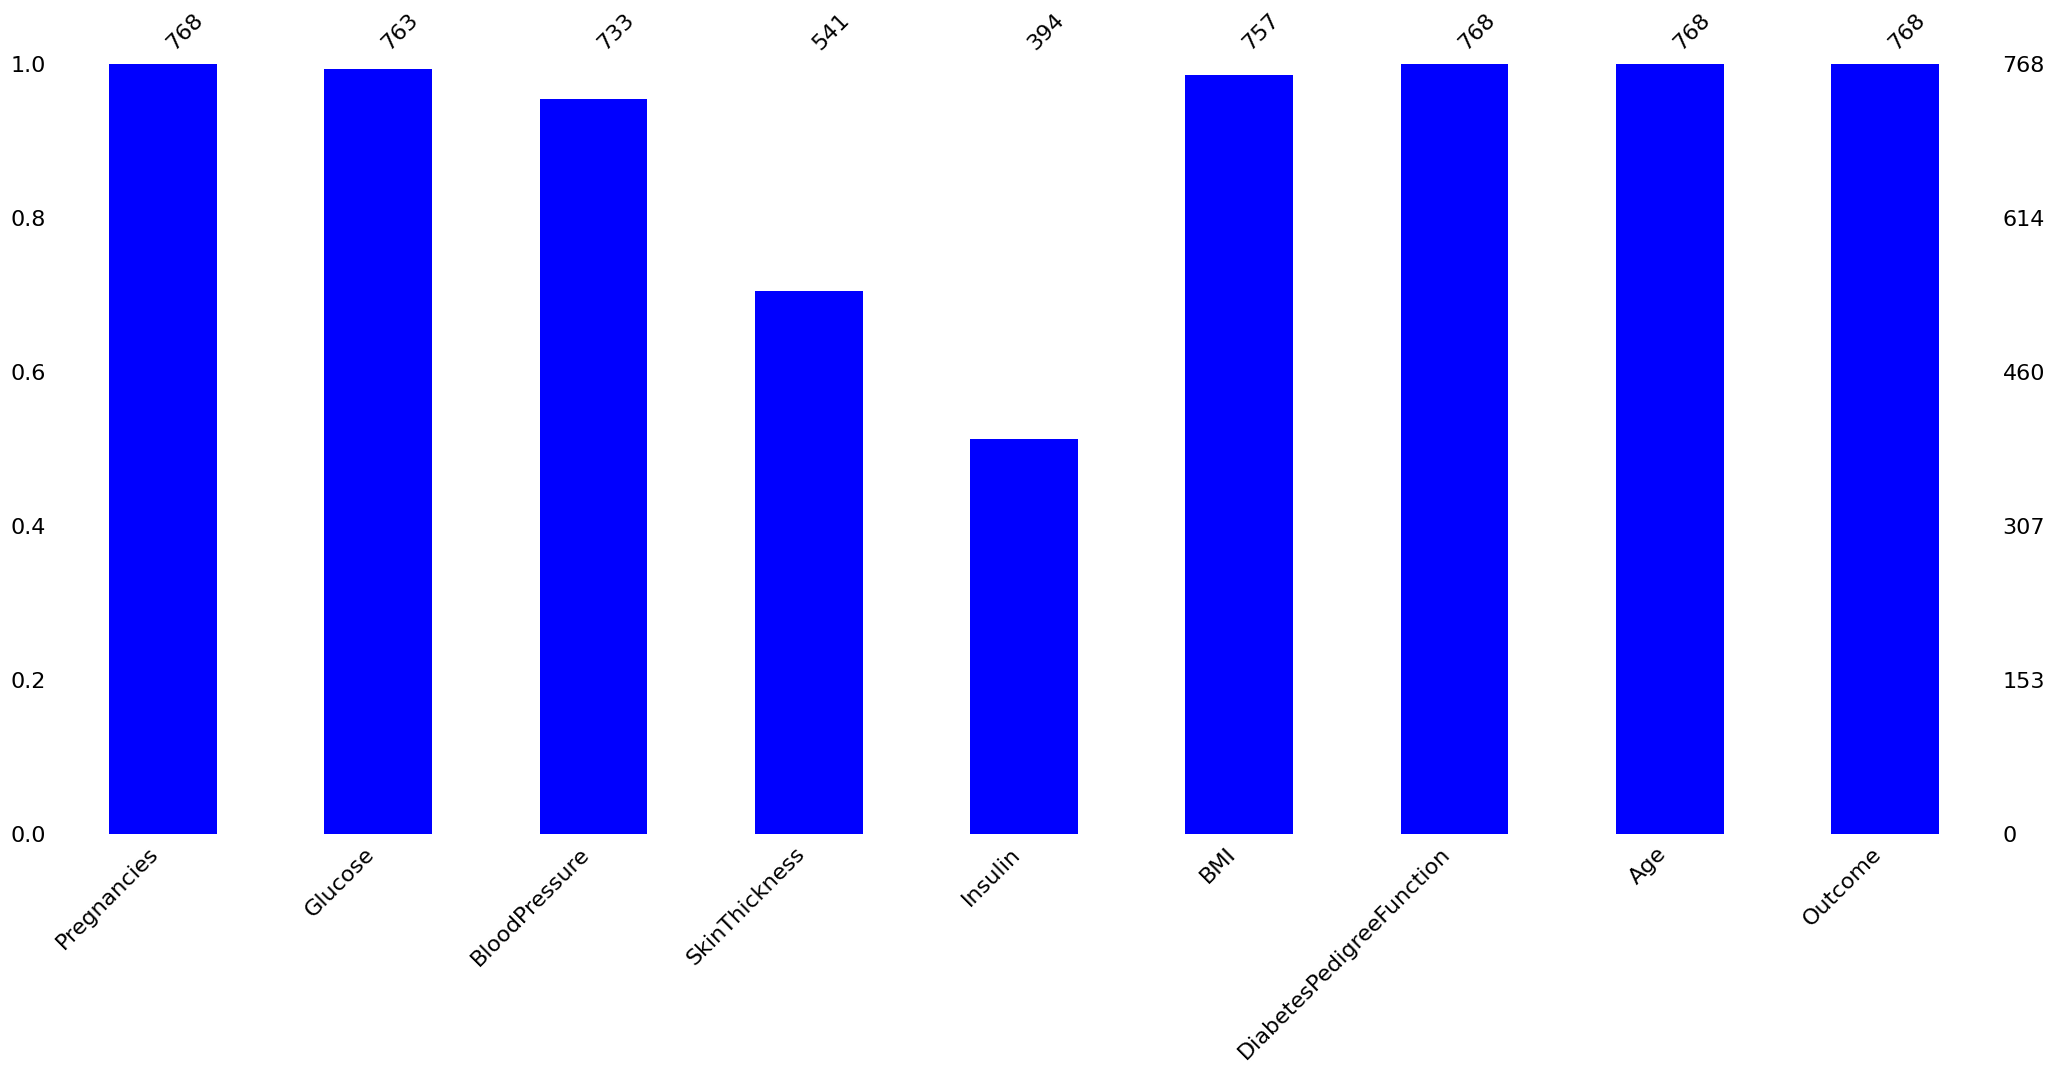

In [10]:
msno.bar(df, color='blue')
plt.show()

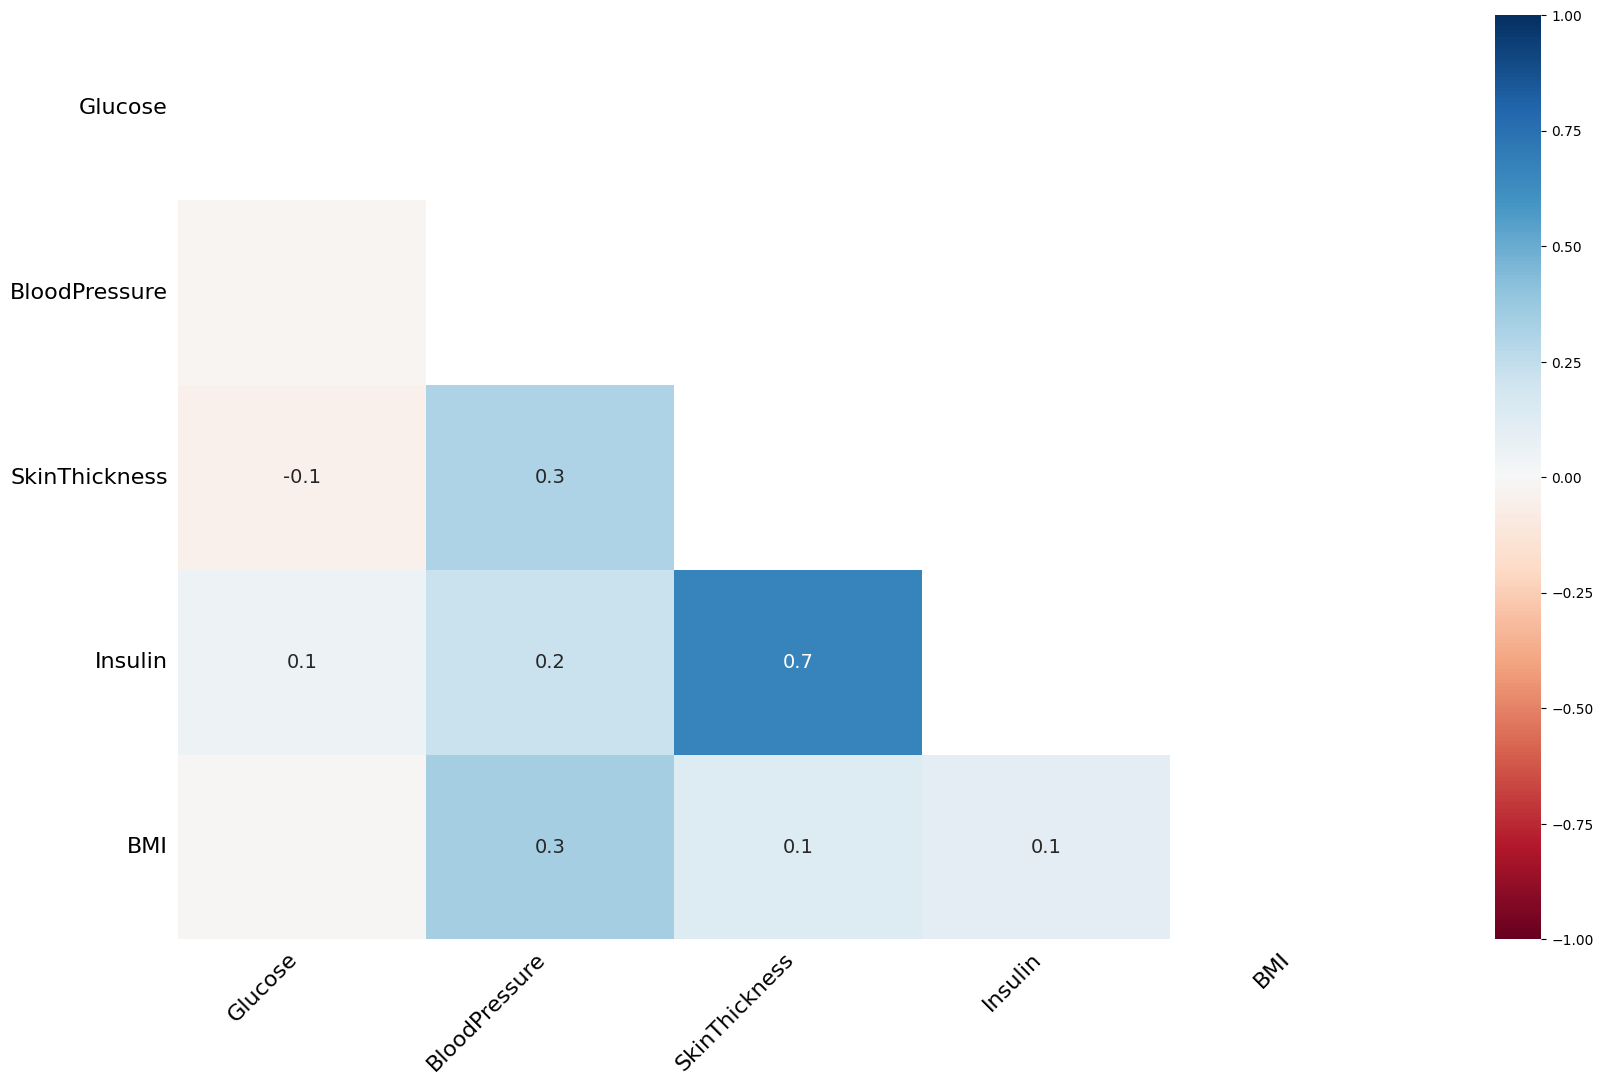

In [11]:
msno.heatmap(df)
plt.show()

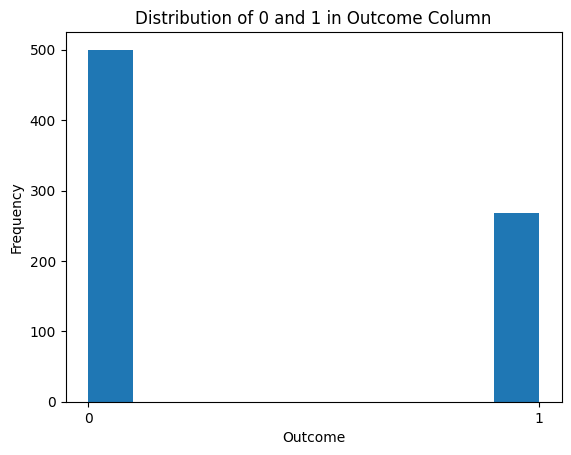

In [12]:
plt.hist(df['Outcome'])
plt.xticks([0, 1])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Distribution of 0 and 1 in Outcome Column')
plt.show()

In [13]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
missing_values_table(df, True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [14]:
df = pd.get_dummies(df[cat_cols + num_cols], drop_first=True, dtype=int)
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
df.sample(5)

Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age
734    0.000        2.000  105.000         75.000         21.800  115.200 23.300                     0.560 53.000
251    0.000        2.000  129.000         84.000         23.000  139.800 28.000                     0.284 27.000
427    1.000        1.000  181.000         64.000         30.000  180.000 34.100                     0.328 38.000
145    0.000        0.000  102.000         75.000         23.000   85.000 31.700                     0.572 21.000
429    1.000        1.000   95.000         82.000         25.000  180.000 35.000                     0.233 43.000

In [15]:
df.isnull().any()

Outcome                     False
Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
dtype: bool

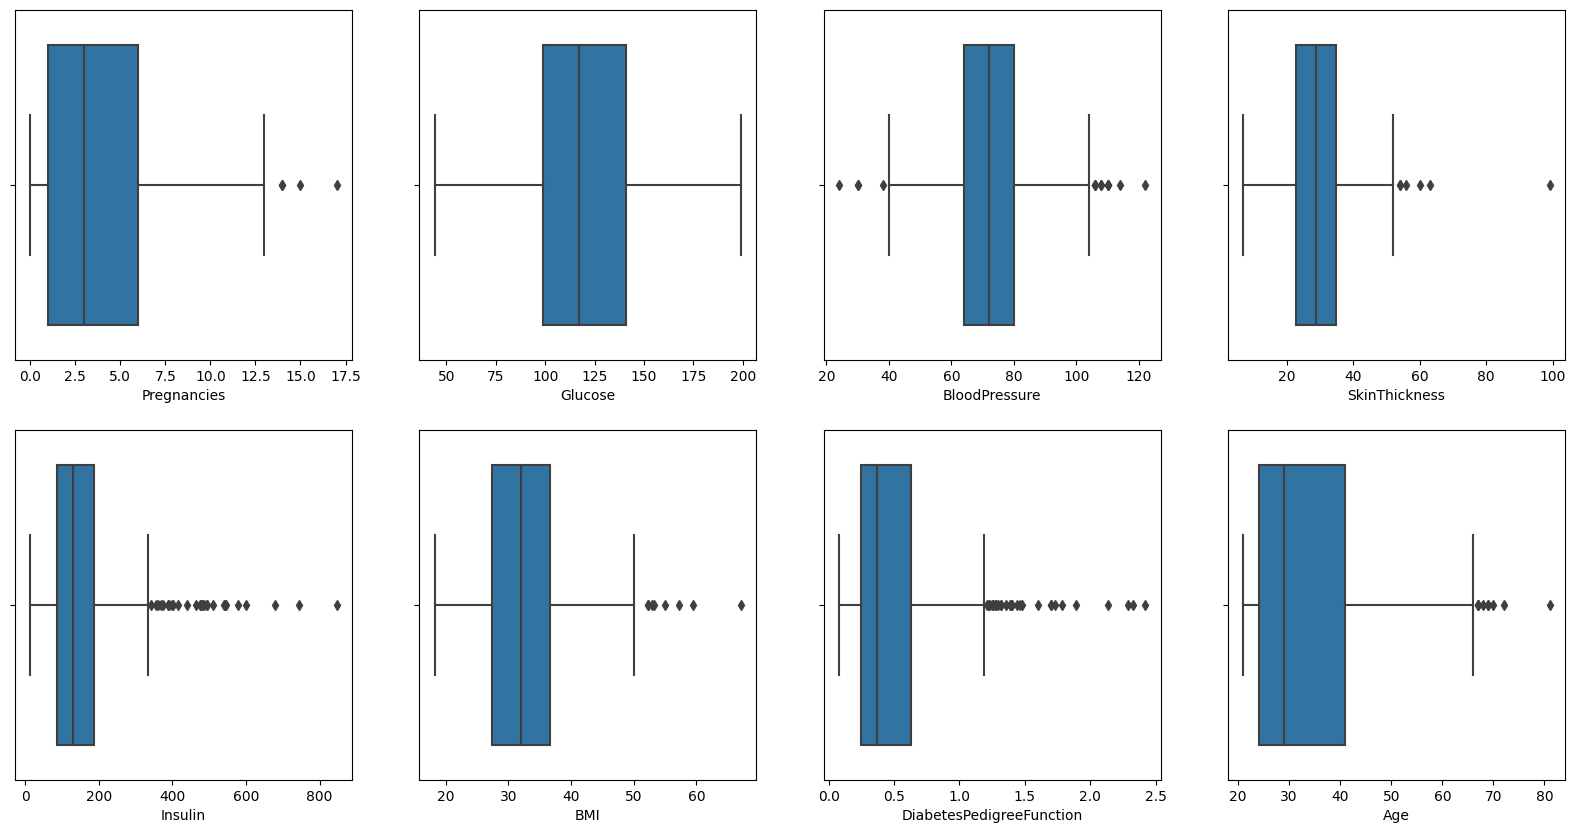

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axs[i//4, i%4])
plt.subplots_adjust(hspace=0.2)
plt.show()

In [17]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    result = f"{col:-<30} {check_outlier(df, col)}"
    print(result)

Pregnancies------------------- True
Glucose----------------------- False
BloodPressure----------------- True
SkinThickness----------------- True
Insulin----------------------- True
BMI--------------------------- True
DiabetesPedigreeFunction------ True
Age--------------------------- True


In [18]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
for col in num_cols:
    result = check_outlier(df, col)
    if result:
        print(col)
        outliers = grab_outliers(df, col)
        print(outliers)
        print("#################################")

Pregnancies
     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age
88     1.000       15.000  136.000         70.000         32.000  110.000 37.100                     0.153 43.000
159    1.000       17.000  163.000         72.000         41.000  114.000 40.900                     0.817 47.000
298    1.000       14.000  100.000         78.000         25.000  184.000 36.600                     0.412 46.000
455    1.000       14.000  175.000         62.000         30.000  199.200 33.600                     0.212 38.000
None
#################################
BloodPressure
     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age
18     0.000        1.000  103.000         30.000         38.000   83.000 43.300                     0.183 33.000
43     1.000        9.000  171.000        110.000         24.000  240.000 45.400                     0.721 54.000
84     1.000        5.0

In [19]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    result = check_outlier(df, col)
    if result:
        print(col)
        outliers = grab_outliers(df, col)
        print(outliers)
        print("#################################")

SkinThickness
     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age
579    1.000        2.000  197.000         70.000         99.000  332.800 34.700                     0.575 62.000
None
#################################
Insulin
     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age
13     1.000        1.000  189.000         60.000         23.000  846.000 30.100                     0.398 59.000
228    0.000        4.000  197.000         70.000         39.000  744.000 36.700                     2.329 31.000
247    0.000        0.000  165.000         90.000         33.000  680.000 52.300                     0.427 23.000
409    1.000        1.000  172.000         68.000         49.000  579.000 42.400                     0.702 28.000
584    1.000        8.000  124.000         76.000         24.000  600.000 28.700                     0.687 52.000
None
######################

In [20]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
for col in num_cols:
    replace_with_thresholds(df, col)
for col in num_cols:
    result = f"{col:-<30} {check_outlier(df, col)}"
    print(result)

Pregnancies------------------- False
Glucose----------------------- False
BloodPressure----------------- False
SkinThickness----------------- False
Insulin----------------------- False
BMI--------------------------- False
DiabetesPedigreeFunction------ False
Age--------------------------- False


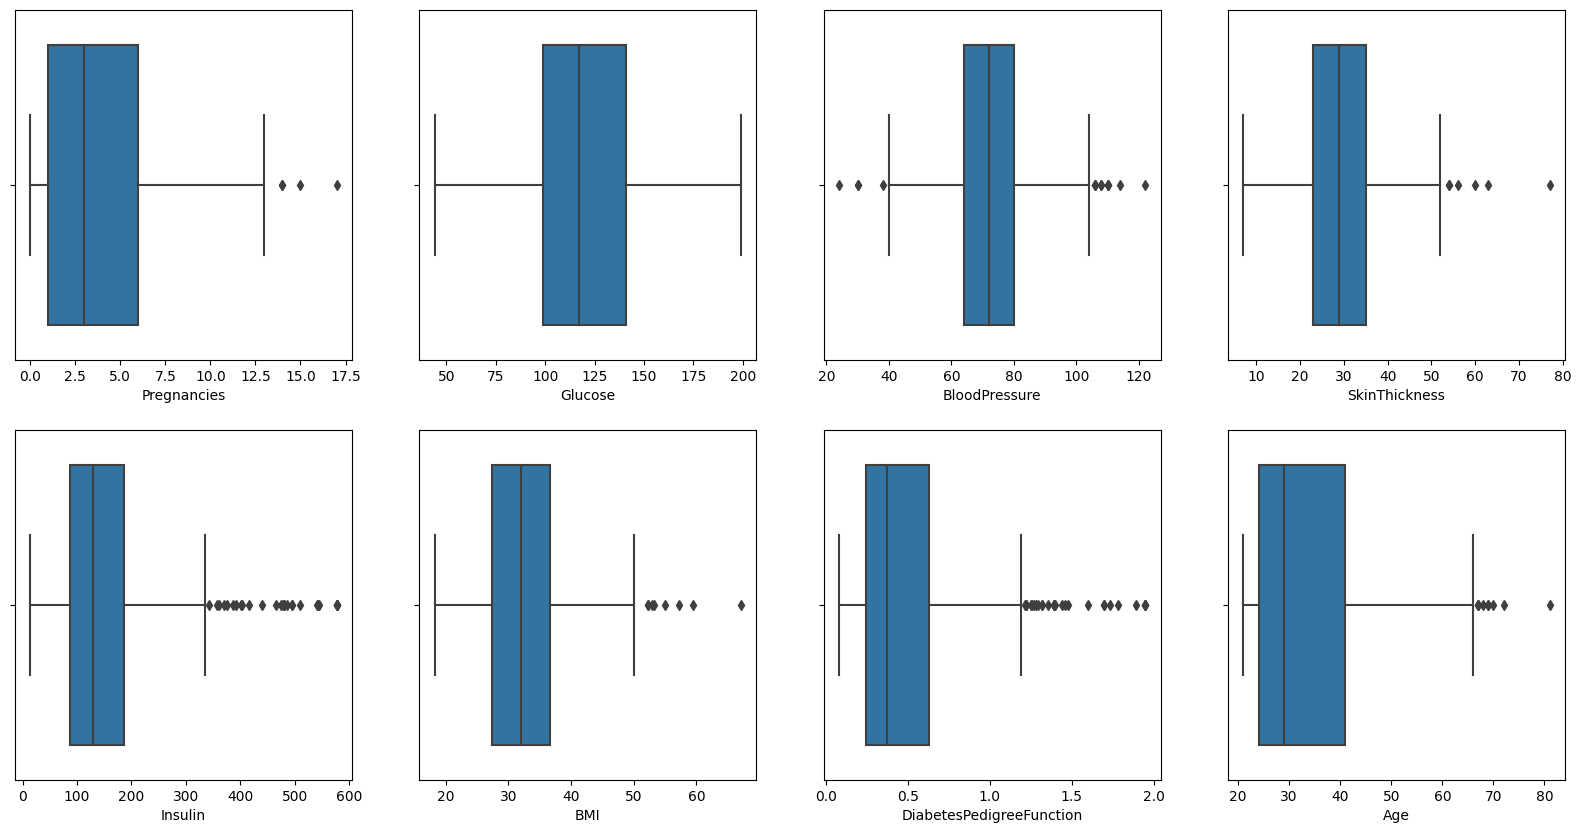

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axs[i//4, i%4])
plt.subplots_adjust(hspace=0.2)
plt.show()

                          Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction   Age
Pregnancies                     1.000    0.131          0.215          0.128    0.112 0.021                    -0.031 0.544
Glucose                         0.131    1.000          0.231          0.224    0.611 0.238                     0.133 0.270
BloodPressure                   0.215    0.231          1.000          0.231    0.146 0.291                     0.001 0.332
SkinThickness                   0.128    0.224          0.231          1.000    0.269 0.674                     0.115 0.136
Insulin                         0.112    0.611          0.146          0.269    1.000 0.313                     0.140 0.226
BMI                             0.021    0.238          0.291          0.674    0.313 1.000                     0.145 0.027
DiabetesPedigreeFunction       -0.031    0.133          0.001          0.115    0.140 0.145                     1.000 0.037
Age     

<Axes: >

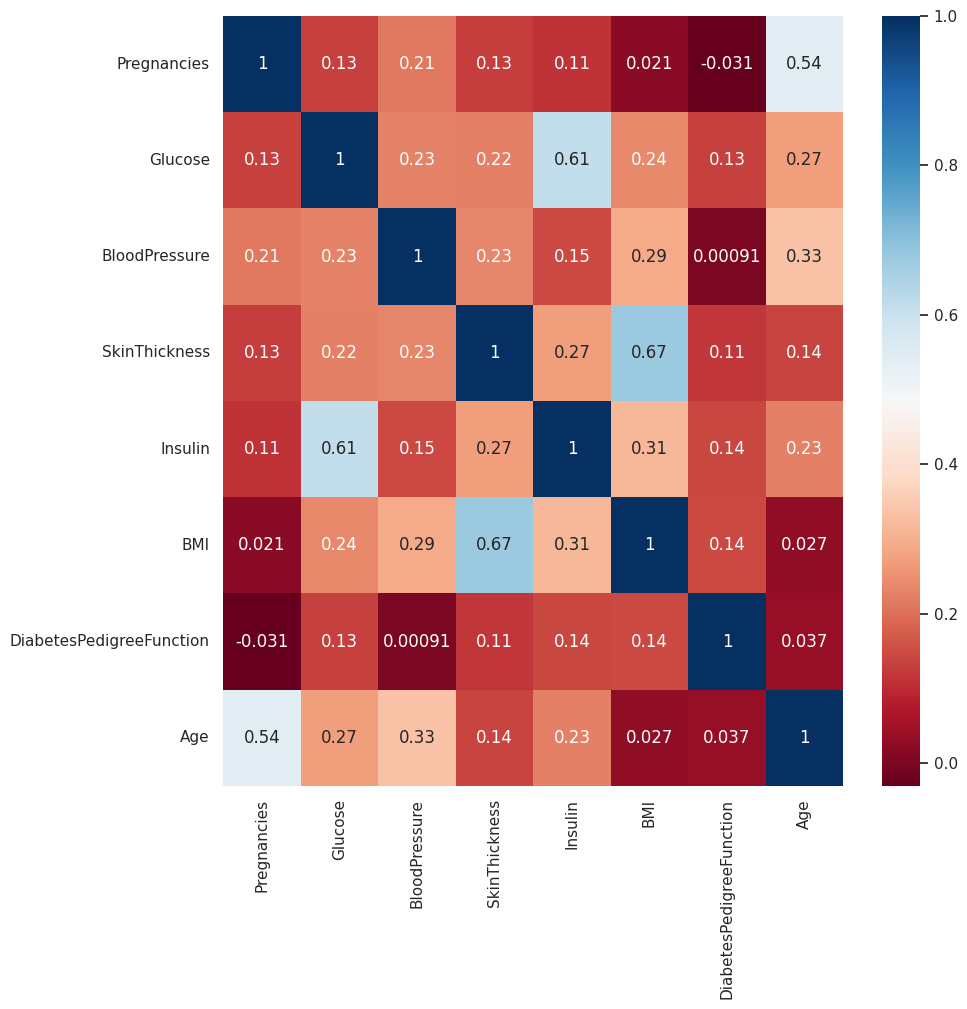

In [22]:
corr = df[num_cols].corr()
print(corr)
sns.set(rc={'figure.figsize': (10, 10)})
sns.heatmap(corr,annot=True,cmap="RdBu")

In [23]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
binary_cols = [col for col in df.columns if df[col].dtype not in ["int64", "float64"]
               and df[col].nunique() == 2]
for col in binary_cols:
    label_encoder(df, col)
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)

In [24]:
def split_data_custom(df, test_size=0.2, validation_size=0.1):
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    adjusted_val_size = validation_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=adjusted_val_size, random_state=42, stratify=y_train_val)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [25]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data_custom(df)

In [26]:
print("Data split into training, validation, and testing sets:")
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Data split into training, validation, and testing sets:
Training set size: (537, 8) (537,)
Validation set size: (77, 8) (77,)
Testing set size: (154, 8) (154,)


In [27]:
class DiabetesModel(nn.Module):
    def __init__(self, input_features):
        super(DiabetesModel, self).__init__()
        self.layer1 = nn.Linear(input_features, 100)  
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(100)
        self.layer2 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.layer3 = nn.Linear(50, 50)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(50, 20)
        self.relu4 = nn.ReLU()
        self.layer5 = nn.Linear(20, 1)
    def forward(self, x):
        x = self.bn1(self.relu1(self.layer1(x)))
        x = self.dropout(self.relu2(self.layer2(x)))
        x = self.relu3(self.layer3(x))
        x = self.relu4(self.layer4(x))
        x = self.layer5(x)
        return x

In [28]:
input_features = X_train.shape[1]
model = DiabetesModel(input_features)

In [29]:
print(model)

DiabetesModel(
  (layer1): Linear(in_features=8, out_features=100, bias=True)
  (relu1): ReLU()
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (layer3): Linear(in_features=50, out_features=50, bias=True)
  (relu3): ReLU()
  (layer4): Linear(in_features=50, out_features=20, bias=True)
  (relu4): ReLU()
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)


In [30]:
def binary_accuracy(y_pred, y_true):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_true).sum().float()
    accuracy = correct_results_sum / y_true.shape[0]
    accuracy = torch.round(accuracy * 100)
    return accuracy

In [31]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [32]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

In [33]:
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.AdamW(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

In [34]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
def train_model(epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            acc = binary_accuracy(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        train_loss = epoch_loss / len(train_loader)
        train_accuracy = epoch_acc / len(train_loader) * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_model(epoch, train_loss, train_accuracy)
       # scheduler.step()

In [35]:
def validate_model(epoch=None, train_loss=None, train_accuracy=None):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            acc = binary_accuracy(y_pred, y_batch)
            val_loss += loss.item()
            val_acc += acc.item()
    average_val_loss = val_loss / len(val_loader)
    average_val_accuracy = val_acc / len(val_loader) * 100
    val_losses.append(average_val_loss)
    val_accuracies.append(average_val_accuracy)
    if epoch is not None and train_loss is not None and train_accuracy is not None:
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {average_val_loss:.4f}, Val Acc: {average_val_accuracy:.2f}%')
    else:
        print(f'Validation | Loss: {average_val_loss:.4f} | Acc: {average_val_accuracy:.2f}%')

In [36]:
train_model(10)  
validate_model() 

Epoch: 1, Train Loss: 0.6610, Train Acc: 6011.76%, Val Loss: 0.6026, Val Acc: 6400.00%
Epoch: 2, Train Loss: 0.5442, Train Acc: 6808.82%, Val Loss: 0.4471, Val Acc: 8600.00%
Epoch: 3, Train Loss: 0.5115, Train Acc: 7314.71%, Val Loss: 0.4420, Val Acc: 8600.00%
Epoch: 4, Train Loss: 0.4772, Train Acc: 7473.53%, Val Loss: 0.4715, Val Acc: 7480.00%
Epoch: 5, Train Loss: 0.4796, Train Acc: 7538.24%, Val Loss: 0.4407, Val Acc: 7600.00%
Epoch: 6, Train Loss: 0.4595, Train Acc: 7850.00%, Val Loss: 0.4064, Val Acc: 8240.00%
Epoch: 7, Train Loss: 0.4609, Train Acc: 7805.88%, Val Loss: 0.4170, Val Acc: 7960.00%
Epoch: 8, Train Loss: 0.4775, Train Acc: 7638.24%, Val Loss: 0.3827, Val Acc: 8600.00%
Epoch: 9, Train Loss: 0.4689, Train Acc: 7773.53%, Val Loss: 0.4110, Val Acc: 8720.00%
Epoch: 10, Train Loss: 0.4626, Train Acc: 7614.71%, Val Loss: 0.4352, Val Acc: 7820.00%
Validation | Loss: 0.4352 | Acc: 7820.00%


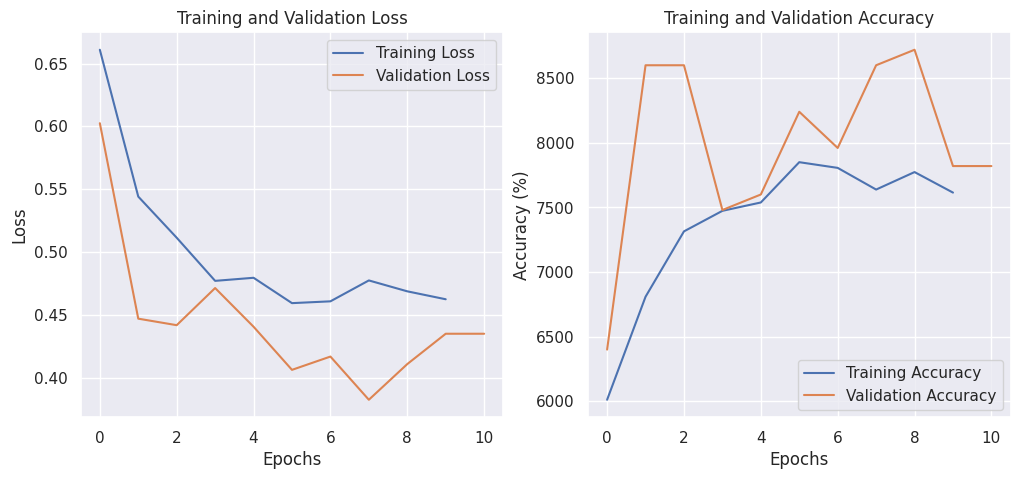

In [37]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [38]:
def evaluate_model_test():
    model.eval()
    with torch.no_grad():
        y_pred_tensor = torch.sigmoid(model(X_test_tensor))  
        y_pred = torch.round(y_pred_tensor)  
    y_test_np = y_test_tensor.numpy()
    y_pred_np = y_pred.detach().numpy()
    conf_matrix = confusion_matrix(y_test_np, y_pred_np)
    f1 = f1_score(y_test_np, y_pred_np)
    recall = recall_score(y_test_np, y_pred_np)
    classification_rep = classification_report(y_test_np, y_pred_np, target_names=['Non-Diabetic', 'Diabetic'])
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nF1-Score: {:.3f}".format(f1))
    print("Recall: {:.3f}".format(recall))
    print("\nClassification Report:")
    print(classification_rep)

In [39]:
evaluate_model_test()

Confusion Matrix:
[[83 17]
 [31 23]]

F1-Score: 0.489
Recall: 0.426

Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.73      0.83      0.78       100
    Diabetic       0.57      0.43      0.49        54

    accuracy                           0.69       154
   macro avg       0.65      0.63      0.63       154
weighted avg       0.67      0.69      0.68       154



In [40]:
def pytorch_predict(data):
    model.eval()
    with torch.no_grad():
        data = torch.tensor(data, dtype=torch.float32)  
        if len(data.shape) == 1:  
            data = data.unsqueeze(0)
        output = model(data)
        probabilities = torch.sigmoid(output)  
        probabilities = probabilities.numpy() 
        return np.hstack((1 - probabilities, probabilities))

In [41]:
X_test_np = X_test_tensor.numpy()

In [42]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, 
    feature_names=X_train.columns.tolist(),
    class_names=['Non-Diabetic', 'Diabetic'],
    mode='classification'
)

In [43]:
np.random.seed(42)
indices = np.random.choice(X_test_np.shape[0], 3, replace=False)
sample1, sample2, sample3 = X_test_np[indices[0]], X_test_np[indices[1]], X_test_np[indices[2]]

In [44]:
print("Selected Indices:", indices)
print("Sample 1 Index:", indices[0], "| Features:", sample1)
print("Sample 2 Index:", indices[1], "| Features:", sample2)
print("Sample 3 Index:", indices[2], "| Features:", sample3)

Selected Indices: [ 15  94 152]
Sample 1 Index: 15 | Features: [  5.   124.    74.    36.8  150.    34.     0.22  38.  ]
Sample 2 Index: 94 | Features: [  5.    136.     84.     41.     88.     35.      0.286  35.   ]
Sample 3 Index: 152 | Features: [4.00e+00 1.84e+02 7.80e+01 3.90e+01 2.77e+02 3.70e+01 2.64e-01 3.10e+01]


In [45]:
for i, sample in enumerate([sample1, sample2, sample3], start=1):
    try:
        explanation = explainer.explain_instance(
            data_row=sample,
            predict_fn=pytorch_predict,
            num_features=len(X_train.columns)
        )
        print(f"\nExplanation for Sample {i}:")
        explanation.show_in_notebook(show_all=False)
    except Exception as e:
        print(f"An error occurred while explaining Sample {i}: {str(e)}")


Explanation for Sample 1:



Explanation for Sample 2:



Explanation for Sample 3:


Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)


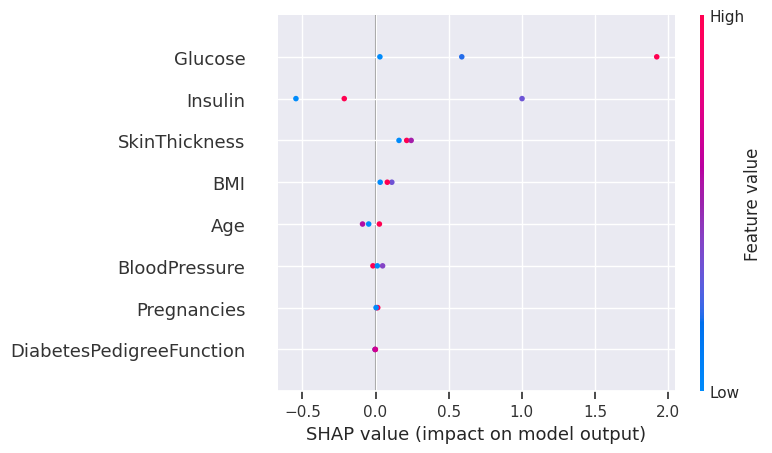

In [46]:
test_samples_tensor = torch.tensor([sample1, sample2, sample3], dtype=torch.float32)
background_data = torch.tensor(X_train.values[:100], dtype=torch.float32) 
explainer = shap.DeepExplainer(model, background_data)
shap_values = explainer.shap_values(test_samples_tensor)
shap.summary_plot(shap_values, features=test_samples_tensor.numpy(), feature_names=X_train.columns.tolist())

In [47]:
print("Expected values:", explainer.expected_value)

Expected values: [-1.114547]


In [48]:
shap.initjs()
for i, shap_value in enumerate(shap_values):
    print(f"\nSHAP Force Plot for Sample {i+1}:")
    display(shap.force_plot(explainer.expected_value[0], shap_value, feature_names=X_train.columns.tolist()))


SHAP Force Plot for Sample 1:



SHAP Force Plot for Sample 2:



SHAP Force Plot for Sample 3:


In [49]:
feature_names = np.array(X_train.columns.tolist())

In [50]:
expected_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value


SHAP Waterfall Plot for Sample 1:


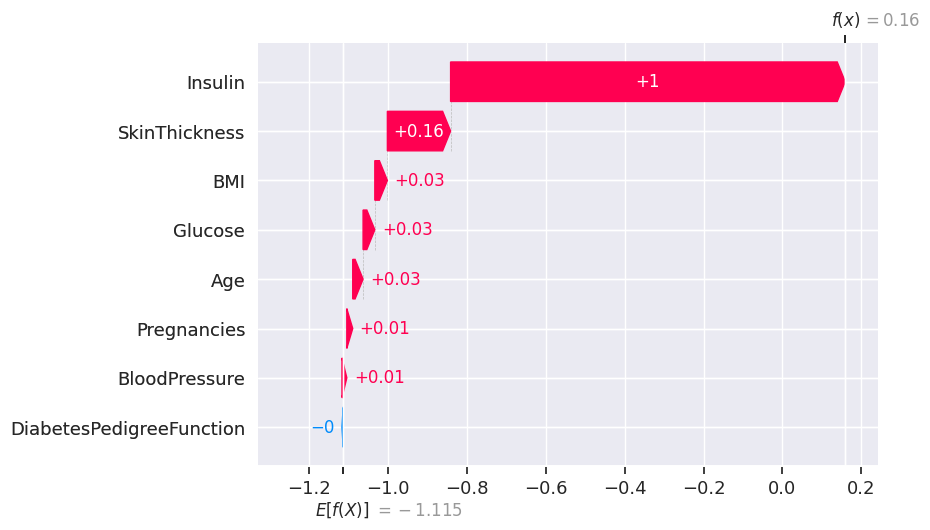


SHAP Waterfall Plot for Sample 2:


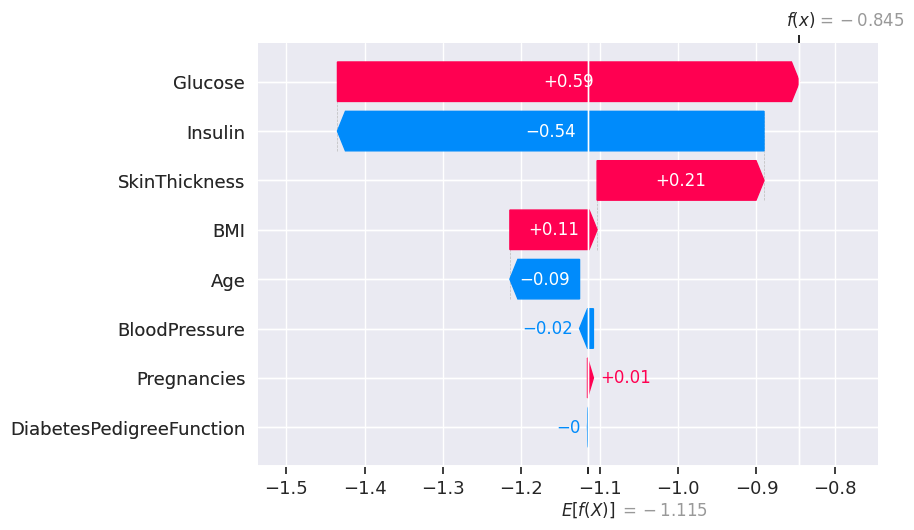


SHAP Waterfall Plot for Sample 3:


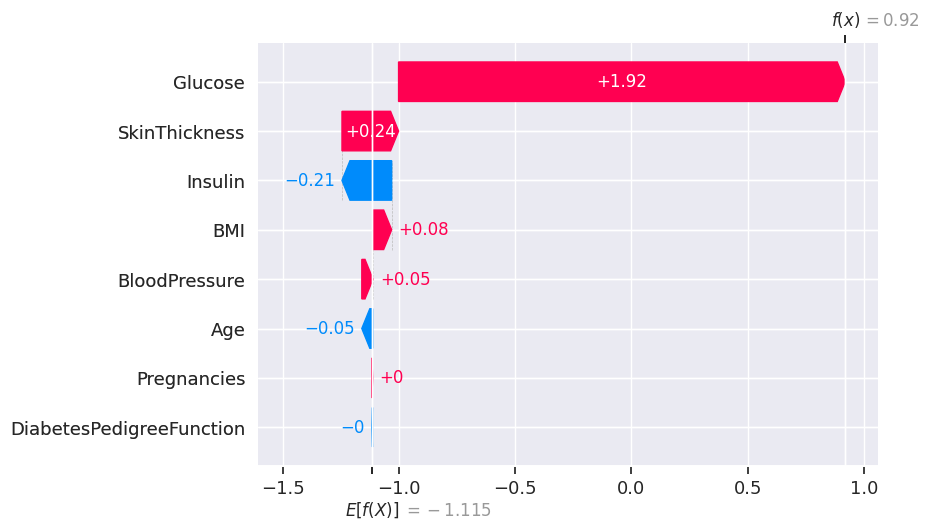

In [51]:
for i, shap_value in enumerate(shap_values):
    print(f"\nSHAP Waterfall Plot for Sample {i+1}:")
    shap.waterfall_plot(shap.Explanation(values=shap_value, 
                                         base_values=expected_value,
                                         feature_names=feature_names))

In [52]:
pip install nam

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

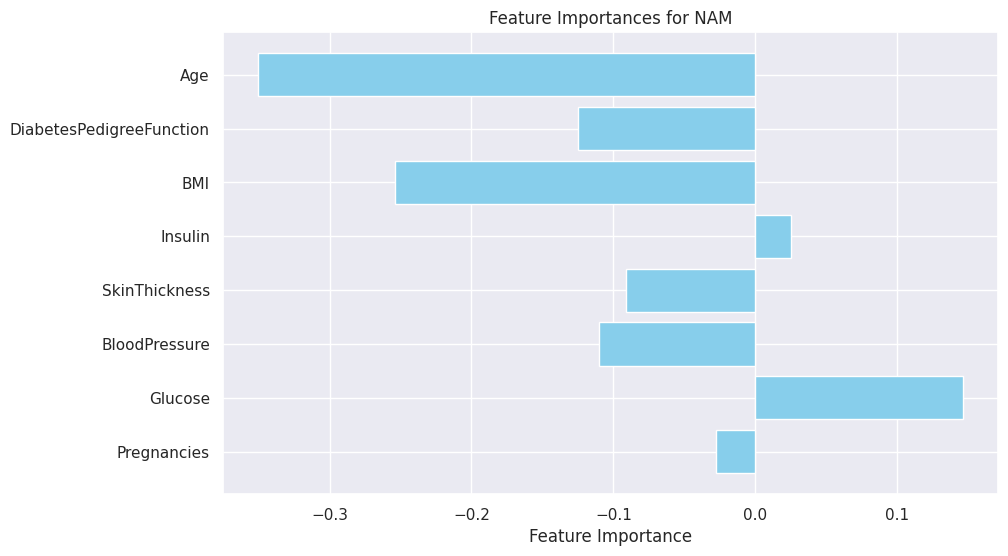

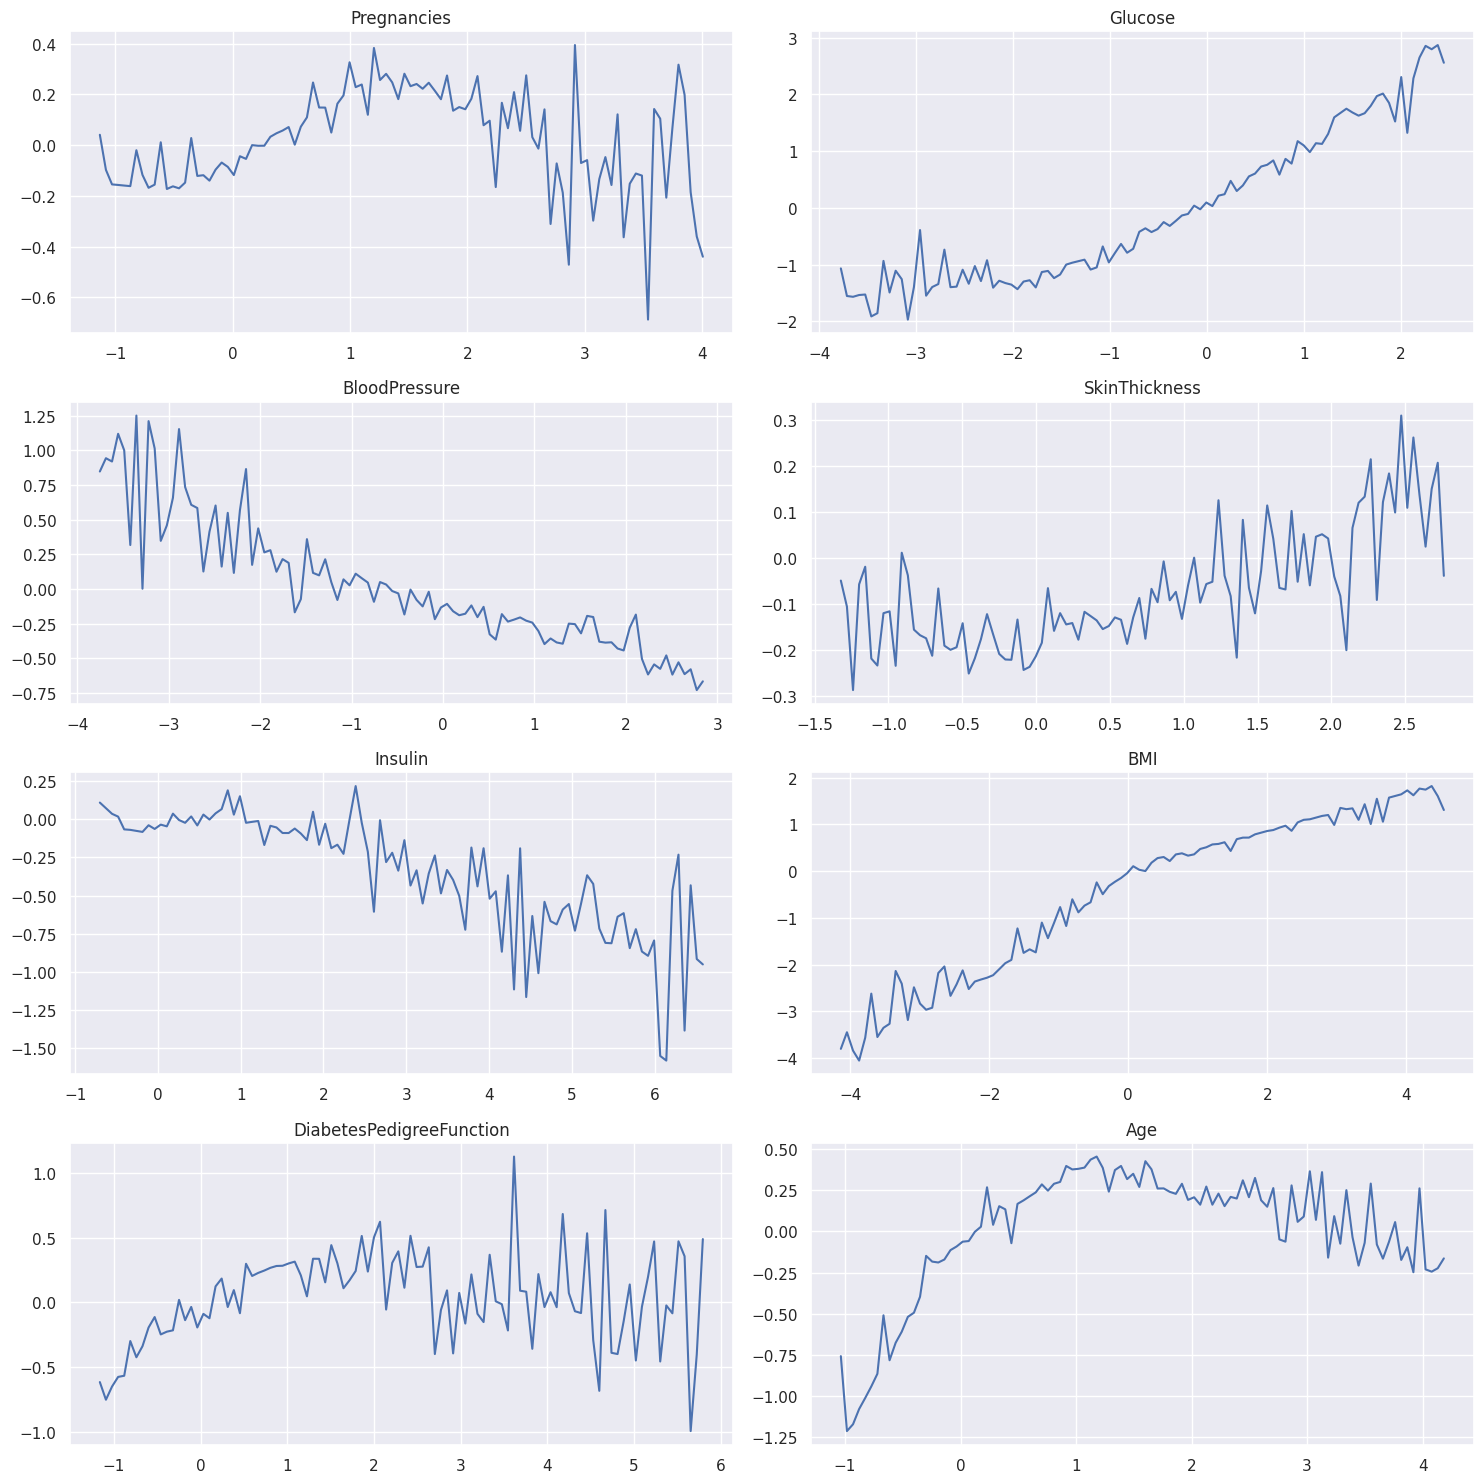

In [54]:
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from typing import Sequence, Tuple

# Step 1: Data Preparation

# Load dataset
df = pd.read_csv("/kaggle/input/diabetes.csv")

# Feature engineering and preprocessing
X = df.drop(columns=["Outcome"])
y = df["Outcome"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


# Step 2: Define the NAM Model

class FeatureNN(nn.Module):
    def __init__(self, config, name, input_shape, num_units, feature_num):
        super(FeatureNN, self).__init__()
        self.config = config
        self.name = name
        self.feature_num = feature_num
        self.layers = nn.Sequential(
            nn.Linear(input_shape, num_units),
            nn.ReLU(),
            nn.Dropout(p=self.config['dropout']),
            nn.Linear(num_units, 1)
        )

    def forward(self, x):
        return self.layers(x)

class NAM(Model):
    def __init__(self, config, name, num_inputs, num_units):
        super(NAM, self).__init__(config, name)
        self.num_inputs = num_inputs
        self.num_units = num_units if isinstance(num_units, list) else [num_units] * num_inputs
        self.feature_nns = nn.ModuleList([
            FeatureNN(config, f'FeatureNN_{i}', 1, self.num_units[i], i) for i in range(num_inputs)
        ])
        self.dropout = nn.Dropout(p=self.config['dropout'])
        self.bias = nn.Parameter(torch.zeros(1))

    def calc_outputs(self, inputs):
        return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self.num_inputs)]

    def forward(self, inputs):
        individual_outputs = self.calc_outputs(inputs)
        concatenated_outputs = torch.cat(individual_outputs, dim=1)
        dropout_outputs = self.dropout(concatenated_outputs)
        output = torch.sum(dropout_outputs, dim=1, keepdim=True)
        return output + self.bias, dropout_outputs


# Step 3: Define the PyTorch Lightning Module for training

class LitNAM(pl.LightningModule):
    def __init__(self, model, config):
        super(LitNAM, self).__init__()
        self.model = model
        self.config = config
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config['learning_rate'])
        return optimizer


# Configuration settings
config = {
    'dropout': 0.1,
    'hidden_sizes': [64, 32],
    'learning_rate': 0.001,
    'num_epochs': 50,
    'batch_size': 32
}

# Initialize NAM model
num_inputs = X_train.shape[1]
num_units = [32] * num_inputs  # Number of units per feature network
model = NAM(config, "DiabetesNAM", num_inputs, num_units)

# Initialize LitNAM for training
lit_model = LitNAM(model, config)

# Set up PyTorch Lightning trainer
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min')
trainer = pl.Trainer(max_epochs=config['num_epochs'], callbacks=[checkpoint_callback])

# Train the model
trainer.fit(lit_model, train_loader, test_loader)

# Step 4: Evaluate and Interpret the Model

# Plotting feature importances
def plot_feature_importances(model, feature_names):
    feature_importances = model.calc_outputs(X_train_tensor)
    mean_importances = [torch.mean(fi).item() for fi in feature_importances]

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, mean_importances, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances for NAM')
    plt.show()

plot_feature_importances(model, X.columns)

# To plot NAMs for individual features
def plot_nams(model, feature_names, num_cols=2):
    num_features = len(feature_names)
    num_rows = (num_features + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axs = axs.flatten()

    for i, (ax, feature_name) in enumerate(zip(axs, feature_names)):
        feature_net = model.feature_nns[i]
        inputs = torch.linspace(X_train_tensor[:, i].min(), X_train_tensor[:, i].max(), steps=100).view(-1, 1)
        outputs = feature_net(inputs).detach().numpy()
        ax.plot(inputs.numpy(), outputs)
        ax.set_title(feature_name)

    for ax in axs[num_features:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

plot_nams(model, X.columns, num_cols=2)
